# Fingerprint bit differences

Investigate for some example fingerprint pairs their bit differences, incl. in 3D.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kissim.encoding import FingerprintGenerator
from kissim.comparison import FingerprintDistanceGenerator

from src.paths import PATH_RESULTS

In [3]:
pd.set_option("display.max_columns", 100)

In [4]:
DATA = PATH_RESULTS / "dfg_in"
COVERAGE_CUTOFF = 0.8

## Load data

In [5]:
%%time
fingerprints_file = DATA / "fingerprints_normalized.json"
fingerprints = FingerprintGenerator.from_json(fingerprints_file)
print(f"Number of fingerprints: {len(fingerprints.data)}")

Number of fingerprints: 4112
CPU times: user 768 ms, sys: 117 ms, total: 885 ms
Wall time: 884 ms


In [6]:
%%time
fingerprint_distance_file = DATA / "fingerprint_distances.csv.bz2"
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")

Number of kinases: 257
Number of structures: 4112
CPU times: user 15.1 s, sys: 426 ms, total: 15.5 s
Wall time: 15.5 s


In [7]:
fingerprint_distance_generator.data.sort_values("distance", ascending=False).head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
1931262,1649,2936,CHK1,VRK3,0.239458,0.980000
1933476,1649,10622,CHK1,Trb1,0.233586,0.982000
3653787,2936,9259,VRK3,PI4K2A,0.227866,0.958667
3653786,2936,9258,VRK3,PI4K2A,0.226433,0.958000
3653788,2936,9260,VRK3,PI4K2A,0.225140,0.942667


In [8]:
fingerprint_distance_generator.data[
    fingerprint_distance_generator.data["kinase.1"]
    != fingerprint_distance_generator.data["kinase.2"]
].sort_values("distance").head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
4280982,3448,4629,JNK3,JNK1,0.010283,0.987333
8017072,10446,12757,ROCK1,ROCK2,0.011370,0.994667
131340,110,1090,ABL2,ABL1,0.011441,0.986667
7459414,8182,10689,ROCK1,ROCK2,0.011827,0.994667
7459913,8182,12744,ROCK1,ROCK2,0.011974,0.994667


In [9]:
kinase_distance_matrix = fingerprint_distance_generator.kinase_distance_matrix(
    coverage_min=COVERAGE_CUTOFF
)

## Get structure pair per kinase pair

In [10]:
def min_structure_pair_per_kinase_pair(fingerprint_distance_generator, kinase1, kinase2):
    """
    For a given kinase pair, get the structure pair used as their representative when
    computing the fingerprint distances.
    """
    data = fingerprint_distance_generator.data
    data_selected = data[
        (data["kinase.1"] == kinase1) & (data["kinase.2"] == kinase2)
        | (data["kinase.1"] == kinase2) & (data["kinase.2"] == kinase1)
    ]
    pair = data_selected.sort_values("distance").iloc[0, :]
    return pair

In [11]:
pair = min_structure_pair_per_kinase_pair(fingerprint_distance_generator, "EGFR", "GAK")
print(kinase_distance_matrix.loc["EGFR", "GAK"])
pair

0.1031889366592613


structure.1        10329
structure.2        12159
kinase.1             GAK
kinase.2            EGFR
distance        0.103189
bit_coverage    0.985333
Name: 7997144, dtype: object

In [12]:
pair2 = min_structure_pair_per_kinase_pair(fingerprint_distance_generator, "EGFR", "ErbB2")
print(kinase_distance_matrix.loc["EGFR", "ErbB2"])
pair2

0.039648300449159


structure.1          821
structure.2         4815
kinase.1            EGFR
kinase.2           ErbB2
distance        0.039648
bit_coverage       0.994
Name: 959516, dtype: object

In [13]:
pair3 = min_structure_pair_per_kinase_pair(fingerprint_distance_generator, "EGFR", "LOK")
print(kinase_distance_matrix.loc["EGFR", "LOK"])
pair3

0.0712398260397196


structure.1         6201
structure.2        10651
kinase.1            EGFR
kinase.2             LOK
distance         0.07124
bit_coverage    0.975333
Name: 6614851, dtype: object

In [14]:
pair6 = min_structure_pair_per_kinase_pair(fingerprint_distance_generator, "EGFR", "SLK")
print(kinase_distance_matrix.loc["EGFR", "SLK"])
pair6

0.076407993319551


structure.1        10625
structure.2        12175
kinase.1             SLK
kinase.2            EGFR
distance        0.076408
bit_coverage    0.990667
Name: 8062332, dtype: object

## Plot fingerprint diffs

In [15]:
def plot_fingerprint_diff(fingerprints, pair, ax):
    """
    Plot fingerprint diff features.
    """

    fp1 = fingerprints.data[pair["structure.1"]]
    fp2 = fingerprints.data[pair["structure.2"]]
    fp_diff_physchem = (fp1.physicochemical.transpose() - fp2.physicochemical.transpose()).abs()
    fp_diff_distances = (fp1.distances.transpose() - fp2.distances.transpose()).abs()
    fp_diff = pd.concat([fp_diff_physchem, fp_diff_distances])

    # Column mean
    fp_diff_col_mean = fp_diff.mean(axis=0)
    fp_diff_col_mean.name = "$\O$"  # noqa: W605
    fp_diff = pd.concat([fp_diff, pd.DataFrame(fp_diff_col_mean).transpose()], axis=0)

    # Row mean
    fp_diff_row_mean = fp_diff.mean(axis=1)
    fp_diff_row_mean.name = "$\O$"  # noqa: W605
    fp_diff = pd.concat([fp_diff, pd.DataFrame(fp_diff_row_mean)], axis=1)
    sns.heatmap(
        fp_diff,
        cmap="Blues",
        ax=ax,
        vmin=0,
        vmax=1,
        xticklabels=range(1, 87),
        cbar_kws={"label": "KiSSim distance difference"},
    )
    xticklabels = [i if i % 2 == 0 else "" for i in range(1, 86)] + ["$\O$"]  # noqa: W605
    ax.set_xticklabels(xticklabels)
    ax.set_ylabel("-".join(sorted([pair["kinase.1"], pair["kinase.2"]])))

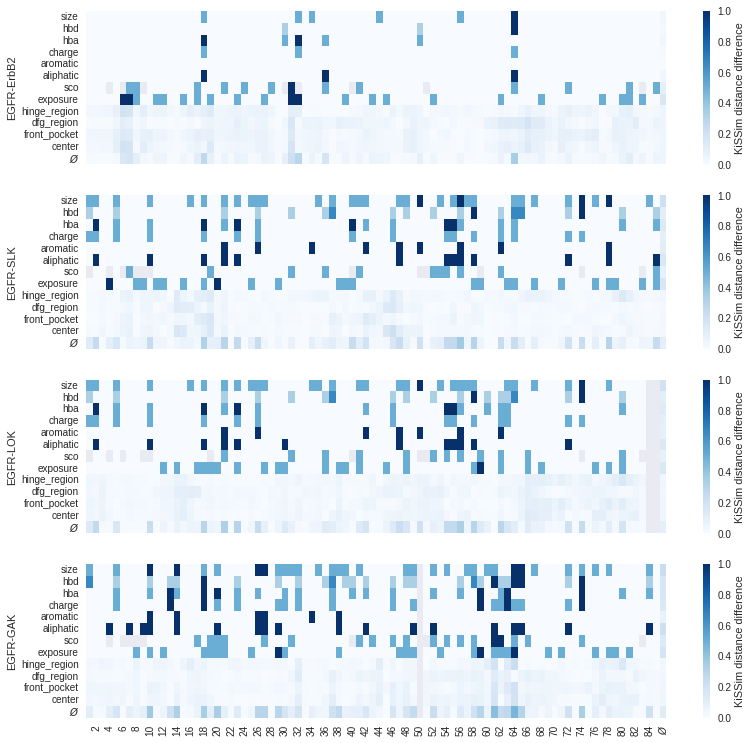

In [16]:
fig, ax = plt.subplots(4, 1, figsize=(13, 13), sharex=True)
plot_fingerprint_diff(fingerprints, pair2, ax[0])
plot_fingerprint_diff(fingerprints, pair6, ax[1])
plot_fingerprint_diff(fingerprints, pair3, ax[2])
plot_fingerprint_diff(fingerprints, pair, ax[3])
plt.savefig("../figures/example_kissim_fp_diff.png", dpi=300, bbox_inches="tight")

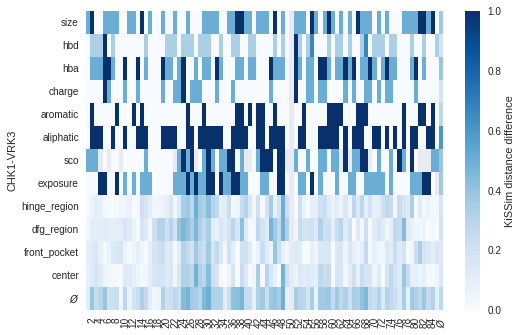

In [18]:
fig, ax = plt.subplots(1, 1)
pair4 = fingerprint_distance_generator.data[
    (fingerprint_distance_generator.data["structure.1"] == 1649)
    & (fingerprint_distance_generator.data["structure.2"] == 2936)
].squeeze()
plot_fingerprint_diff(fingerprints, pair4, ax)

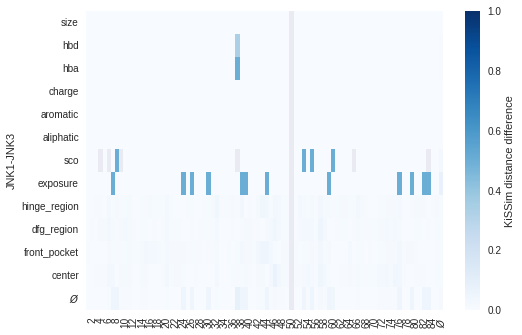

In [19]:
fig, ax = plt.subplots(1, 1)
pair5 = fingerprint_distance_generator.data[
    (fingerprint_distance_generator.data["structure.1"] == 3448)
    & (fingerprint_distance_generator.data["structure.2"] == 4629)
].squeeze()
plot_fingerprint_diff(fingerprints, pair5, ax)

In [21]:
def plot_fp_diff(pair, ax, bits=[True, True, True]):
    """
    Plot fingerprint difference bit values as histogram.
    Define with `bits` which feature types to show:
    [physchem, distances, moments]
    """
    fp1 = fingerprints.data[pair["structure.1"]]
    fp2 = fingerprints.data[pair["structure.2"]]
    fp_diff = fp1.values_array(*bits) - fp2.values_array(*bits)
    ax.hist(fp_diff, bins=100)
    ax.set_title(
        f"{pair['kinase.1']} ({pair['structure.1']}) and "
        f"{pair['kinase.2']} ({pair['structure.2']})"
    )
    ax.set_xlim([-1, 1])

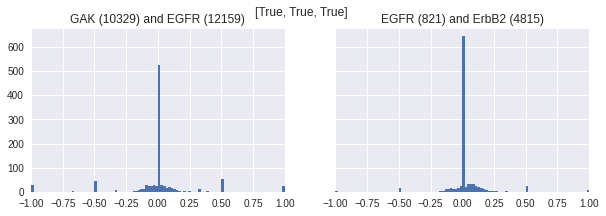

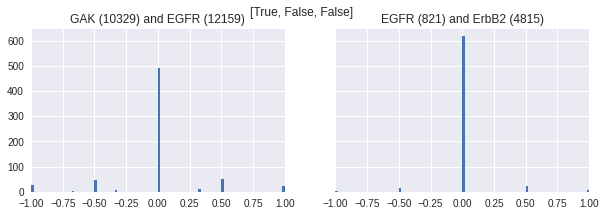

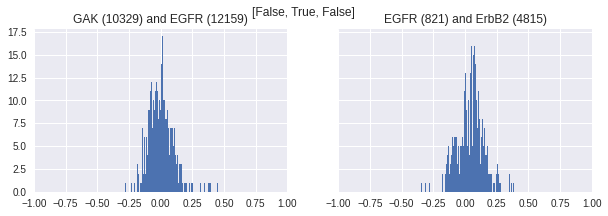

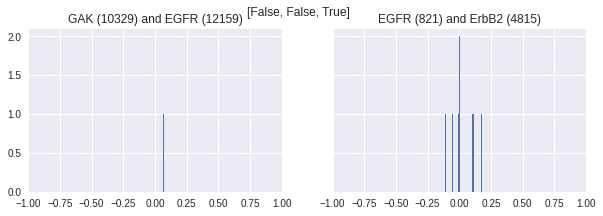

In [22]:
for i, bits in enumerate(
    [[True, True, True], [True, False, False], [False, True, False], [False, False, True]]
):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
    plot_fp_diff(pair, axes[0], bits)
    plot_fp_diff(pair2, axes[1], bits)
    fig.suptitle(bits)

## Investigate fingerprint diffs

In [23]:
def bits_with_large_diffs(fingerprints, pair, cutoffs=[0.5, 0.15]):
    """
    Get bit positions with large difference between two fingerprints.
    "Large" is defined by `cutoffs`;
    a cutoff for the physchem and distances features.
    """
    fp1 = fingerprints.data[pair["structure.1"]]
    fp2 = fingerprints.data[pair["structure.2"]]

    fp_diff_physicochemical = abs(fp1.physicochemical.unstack() - fp2.physicochemical.unstack())
    fp_diff_physicochemical = fp_diff_physicochemical[
        fp_diff_physicochemical > cutoffs[0]
    ].unstack()
    fp_diff_distances = abs(fp1.distances.unstack() - fp2.distances.unstack())
    fp_diff_distances = fp_diff_distances[fp_diff_distances > cutoffs[1]].unstack()
    fp_diff = pd.concat([fp_diff_physicochemical, fp_diff_distances])

    feature_names_physicochemical = [
        "size",
        "hbd",
        "hba",
        "charge",
        "aromatic",
        "aliphatic",
        "sco",
        "exposure",
    ]
    feature_names_physicochemical = [
        i for i in fp_diff.index if (i in feature_names_physicochemical)
    ]
    feature_names_distances = ["hinge_region", "dfg_region", "front_pocket", "center"]
    feature_names_distances = [i for i in fp_diff.index if (i in feature_names_distances)]

    return (
        fp_diff,
        fp_diff.loc[feature_names_physicochemical].max().dropna(),
        fp_diff.loc[feature_names_distances].max().dropna(),
    )

In [24]:
bits = bits_with_large_diffs(fingerprints, pair)
print(len(bits[1]), len(bits[2]))
bits[0]

28 14


residue.ix,1,4,7,9,10,13,14,16,18,20,26,27,29,32,34,37,38,42,44,46,48,49,52,58,59,60,61,62,63,64,65,66,72,74,77,80,84
size,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN
hbd,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,1.000000,NaN,NaN,1.000000,1.0,NaN,NaN,1.0,NaN,NaN,NaN
hba,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
charge,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
aromatic,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aliphatic,NaN,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,1.0,NaN,1.0,NaN,NaN,NaN,1.0
sco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exposure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hinge_region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.181386,NaN,NaN,NaN,NaN,NaN,0.180688,NaN,NaN,NaN,NaN,0.21035,NaN,NaN,NaN,NaN,NaN,NaN,0.189998,0.380496,NaN,0.241663,0.452432,NaN,NaN,NaN,NaN,0.157143,0.284429,NaN
dfg_region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229119,NaN,0.150699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.163931,NaN,NaN,0.228481,NaN,0.152495,NaN,NaN,0.174811,NaN,NaN,NaN,NaN,NaN


In [25]:
bits2 = bits_with_large_diffs(fingerprints, pair2)
print(len(bits2[1]), len(bits2[2]))
bits2[0]

7 30


residue.ix,5,6,7,9,10,16,17,18,19,23,31,32,36,38,49,61,62,63,64,65,66,67,68,71,72,75,76,79,80,81,82
size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hbd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aliphatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exposure,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hinge_region,NaN,0.386926,0.340296,0.209936,NaN,0.190567,NaN,0.182246,0.263865,NaN,0.187318,0.172172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155525,NaN,NaN,NaN,0.155116,NaN,NaN,NaN,0.156566,0.189349,NaN
dfg_region,NaN,0.197251,0.153731,NaN,NaN,NaN,NaN,NaN,NaN,0.171255,0.314077,NaN,NaN,0.151083,NaN,0.152764,0.238546,0.259682,0.235288,0.258329,0.352524,0.249623,0.248136,NaN,NaN,NaN,NaN,0.15463,NaN,NaN,0.218335
front_pocket,0.170636,0.278534,0.264630,0.159496,0.174995,NaN,0.169201,NaN,0.166837,NaN,0.278334,NaN,NaN,NaN,0.156175,NaN,NaN,NaN,NaN,NaN,0.226773,0.172058,0.159269,0.175887,0.177283,0.175621,0.196151,NaN,NaN,NaN,NaN
center,0.181711,0.368814,0.351055,0.206444,NaN,NaN,NaN,NaN,0.258284,NaN,0.347363,NaN,NaN,NaN,0.150690,NaN,NaN,0.165730,NaN,0.178510,0.270303,0.165848,NaN,0.164311,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
def diff_stats(bits):
    """
    For each KLIFS position with large diffs, get
    - position index
    - feature with maximal diff
    - maximal diff value
    - number of features with large diffs
    """
    bits_max = []
    for index, col in bits[0].iteritems():
        a = col.dropna().sort_values(ascending=False).reset_index()
        bits_max.append([index, a.iloc[0, 0], a.iloc[0, 1], len(a)])
    return pd.DataFrame(bits_max, columns=["position", "feature", "max_diff", "n_diffs"])

In [27]:
diff_stats(bits)

,position,feature,max_diff,n_diffs
0,1,hbd,0.666667,1
1,4,aliphatic,1.000000,1
2,7,aliphatic,1.000000,1
3,9,aliphatic,1.000000,1
4,10,size,1.000000,3
5,13,hba,1.000000,2
6,14,size,1.000000,3
7,16,hinge_region,0.181386,1
8,18,hbd,1.000000,3
9,20,hba,1.000000,2


In [28]:
diff_stats(bits2)

,position,feature,max_diff,n_diffs
0,5,center,0.181711,2
1,6,exposure,1.000000,5
2,7,exposure,1.000000,5
3,9,hinge_region,0.209936,3
4,10,front_pocket,0.174995,1
5,16,hinge_region,0.190567,1
6,17,front_pocket,0.169201,1
7,18,hba,1.000000,3
8,19,hinge_region,0.263865,3
9,23,dfg_region,0.171255,1


## Visualize fingerprint diff in 3D

In [29]:
from kissim.viewer import StructurePairViewer

In [30]:
from opencadd.databases.klifs import setup_remote

In [31]:
session = setup_remote()

In [32]:
viewer = StructurePairViewer.from_structure_klifs_ids(pair["structure.1"], pair["structure.2"])
viewer.show()

interactive(children=(Dropdown(description='Feature: ', options=('size', 'hbd', 'hba', 'charge', 'aromatic', '…

In [33]:
_id = pair2["structure.2"]
print(_id)
pocket = session.pockets.by_structure_klifs_id(_id)
pocket_subset = diff_stats(bits2)
residue_ids = pd.merge(
    pocket_subset, pocket, how="left", left_on="position", right_on="residue.klifs_id"
)["residue.id"].to_list()
" or ".join(residue_ids)

4815


'728 or 729 or 730 or 732 or 733 or 752 or 753 or 754 or 755 or 769 or 777 or 778 or 783 or 785 or 802 or 836 or 837 or 838 or 839 or 840 or 841 or 842 or 843 or 846 or 847 or 850 or 851 or 861 or 862 or 863 or 864'

In [35]:
viewer1 = StructurePairViewer.from_structure_klifs_ids(pair2["structure.1"], pair2["structure.2"])
viewer1.show()

interactive(children=(Dropdown(description='Feature: ', options=('size', 'hbd', 'hba', 'charge', 'aromatic', '…

## Visualize fingerprint diff in 3D - version 2

In [36]:
from opencadd.structure.pocket import PocketKlifs, PocketViewer

In [37]:
def visualize_large_diff_residues(kinase1, kinase2, fingerprints, fingerprint_distance_generator):
    """
    Between two kinases show representative structures and all pocket residues with large
    fingerprint diffs:
    - blue: large physchem diff
    - yellow: large distance diff
    - green: large diff in both categories
    """

    pair = min_structure_pair_per_kinase_pair(fingerprint_distance_generator, kinase1, kinase2)
    print(pair)
    bits = bits_with_large_diffs(fingerprints, pair)

    # Get KLIFS residue IDs
    subset_res_physchem = bits[1].index.to_list()
    subset_res_distances = bits[2].index.to_list()
    subset_residue_klifs_ids = {}
    subset_residue_klifs_ids["both"] = list(set(subset_res_physchem) & set(subset_res_distances))
    subset_residue_klifs_ids["physchem"] = list(
        set(subset_res_physchem) - set(subset_res_distances)
    )
    subset_residue_klifs_ids["dist"] = list(set(subset_res_distances) - set(subset_res_physchem))

    # Get PDB residue IDs
    subset_residue_ids = {}
    for _id in [pair["structure.1"], pair["structure.2"]]:
        subset_residue_ids[_id] = {}
        pocket = session.pockets.by_structure_klifs_id(_id)
        for _type, subset in subset_residue_klifs_ids.items():
            subset_residue_ids[_id][_type] = pocket[pocket["residue.klifs_id"].isin(subset)][
                "residue.id"
            ].to_list()

    v = PocketViewer()
    # colors = {"both": "green", "physchem": "blue", "dist": "yellow"}
    colors = [
        {"both": "green", "physchem": "blue", "dist": "yellow"},
        {"both": "lightgreen", "physchem": "lightblue", "dist": "lightyellow"},
    ]
    i = 0
    for _id, subsets in subset_residue_ids.items():
        pocket = PocketKlifs.from_structure_klifs_id(_id)
        v.add_pocket(pocket, None, False, False, False, False)
        for _type, subset in subsets.items():
            if len(subset_residue_ids[_id][_type]) > 0:
                selection = " or ".join(subset_residue_ids[_id][_type])
                v.viewer.add_representation(
                    "ball+stick",
                    selection=selection,
                    color=colors[i][_type],
                    name=f"diffs {_id} {_type}",
                    component=v._components_structures[_id],
                )
        i += 1

    return v.viewer

In [38]:
view1 = visualize_large_diff_residues("EGFR", "GAK", fingerprints, fingerprint_distance_generator)
view1.gui_style = "NGL"
view1

structure.1        10329
structure.2        12159
kinase.1             GAK
kinase.2            EGFR
distance        0.103189
bit_coverage    0.985333
Name: 7997144, dtype: object


NGLWidget(gui_style='ngl')

In [39]:
view2 = visualize_large_diff_residues(
    "EGFR", "ErbB2", fingerprints, fingerprint_distance_generator
)
view2.gui_style = "NGL"
view2

structure.1          821
structure.2         4815
kinase.1            EGFR
kinase.2           ErbB2
distance        0.039648
bit_coverage       0.994
Name: 959516, dtype: object


NGLWidget(gui_style='ngl')

In [40]:
view3 = visualize_large_diff_residues("EGFR", "LOK", fingerprints, fingerprint_distance_generator)
view3.gui_style = "NGL"
view3

structure.1         6201
structure.2        10651
kinase.1            EGFR
kinase.2             LOK
distance         0.07124
bit_coverage    0.975333
Name: 6614851, dtype: object


NGLWidget(gui_style='ngl')